In [89]:
from keras.backend import clear_session
clear_session()  # Run before model creation

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import cv2


In [7]:
# Function to load YOLO annotations and convert to pixel coordinates
def load_yolo_annotations(txt_path, img_width, img_height):
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    
    points = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 3:  # At least class, x_center, y_center
            x_center = float(parts[1]) * img_width
            y_center = float(parts[2]) * img_height
            points.append([x_center, y_center])
    return np.array(points)

In [8]:
# Modified density map creation for YOLO format
def create_density_map(image_shape, txt_path, sigma=5, scale=10000):
    # Load annotations and convert from normalized to absolute coordinates
    head_locations = load_yolo_annotations(txt_path, image_shape[1], image_shape[0])
    
    density_map = np.zeros(image_shape[:2])
    for x, y in head_locations:
        # Ensure coordinates are within image bounds
        x = min(max(0, int(x)), image_shape[1]-1)
        y = min(max(0, int(y)), image_shape[0]-1)
        density_map[y, x] += 1
    
    return gaussian_filter(density_map, sigma=sigma) * scale

In [3]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.12.0
GPU disponible: False


In [ ]:
# List first 10 actual image files in your directory
root = 'C:/Users/yasmi/Documents/detection/bdd/train'
import os
actual_images = sorted(os.listdir(os.path.join(root, 'images')))
print("First 10 actual images:", actual_images[:10])

First 10 actual images: ['02ef2a0c-20250409_141514.jpg', '04ba1e31-20250409_141939.jpg', '0551193c-20250409_142422.jpg', '07e09b83-20250409_141935.jpg', '088a0f65-20250409_141741.jpg', '096f2d11-20250409_143744.jpg', '0cb465ff-20250409_141820.jpg', '0d959989-20250409_140958.jpg', '11521c96-20250409_143800.jpg', '14912362-20250409_142055.jpg']


In [11]:
import os
import pandas as pd

# Get the actual image names from your directory
image_dir = os.path.join(root, 'images')
actual_images = sorted(os.listdir(image_dir))

# Create DataFrame using ACTUAL image names
df = pd.DataFrame({
    'image_name': actual_images,
    'image_id': range(1, len(actual_images)+1)  # Optional: add sequential IDs
})

print(f"Found {len(df)} images")
print(df.head())

Found 116 images
                     image_name  image_id
0  02ef2a0c-20250409_141514.jpg         1
1  04ba1e31-20250409_141939.jpg         2
2  0551193c-20250409_142422.jpg         3
3  07e09b83-20250409_141935.jpg         4
4  088a0f65-20250409_141741.jpg         5


In [12]:
import os
import pandas as pd

# Get the actual image names from your directory
image_dir = os.path.join(root, 'images')
actual_images = sorted(os.listdir(image_dir))

# Create DataFrame using ACTUAL image names
df = pd.DataFrame({
    'image_name': actual_images,
    'image_id': range(1, len(actual_images)+1)  # Optional: add sequential IDs
})

print(f"Found {len(df)} images")
print(df.head())

Found 116 images
                     image_name  image_id
0  02ef2a0c-20250409_141514.jpg         1
1  04ba1e31-20250409_141939.jpg         2
2  0551193c-20250409_142422.jpg         3
3  07e09b83-20250409_141935.jpg         4
4  088a0f65-20250409_141741.jpg         5


In [13]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, root_dir, batch_size=8, shuffle=True):
        self.df = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.root_dir = root_dir
        if shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df[idx*self.batch_size : (idx+1)*self.batch_size]
        
        X_batch = []
        y_batch = []
        
        for _, row in batch_df.iterrows():
            # Image loading
            img_path = os.path.join(self.root_dir, 'images', row.image_name)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load: {img_path}")
                continue
            
            # Annotation loading
            base_name = os.path.splitext(row.image_name)[0]
            txt_path = os.path.join(self.root_dir, 'labels', f"{base_name}.txt")
            
            if not os.path.exists(txt_path):
                print(f"Missing annotation: {txt_path}")
                continue
                
            # Process image and create density map
            image = image.astype(np.float32) / 255.0
            density_map = create_density_map(image.shape, txt_path)
            
            X_batch.append(image)
            y_batch.append(density_map)
        
        return np.array(X_batch), np.expand_dims(np.array(y_batch), -1)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [14]:
def create_density_map(image_shape, annotation_path, sigma=5, scale=10000):
    # Load YOLO annotations
    with open(annotation_path, 'r') as f:
        annotations = [line.strip().split() for line in f.readlines()]
    
    # Convert from YOLO (normalized) to pixel coordinates
    height, width = image_shape[:2]
    points = []
    for ann in annotations:
        if len(ann) >= 3:  # At least class, x_center, y_center
            x = float(ann[1]) * width
            y = float(ann[2]) * height
            points.append([x, y])
    
    # Create density map
    density_map = np.zeros((height, width))
    for x, y in points:
        x, y = int(round(x)), int(round(y))
        if 0 <= x < width and 0 <= y < height:
            density_map[y, x] += 1
    
    return gaussian_filter(density_map, sigma=sigma) * scale

Batch shape - X: (4, 2448, 2448, 3), y: (4, 2448, 2448, 1)


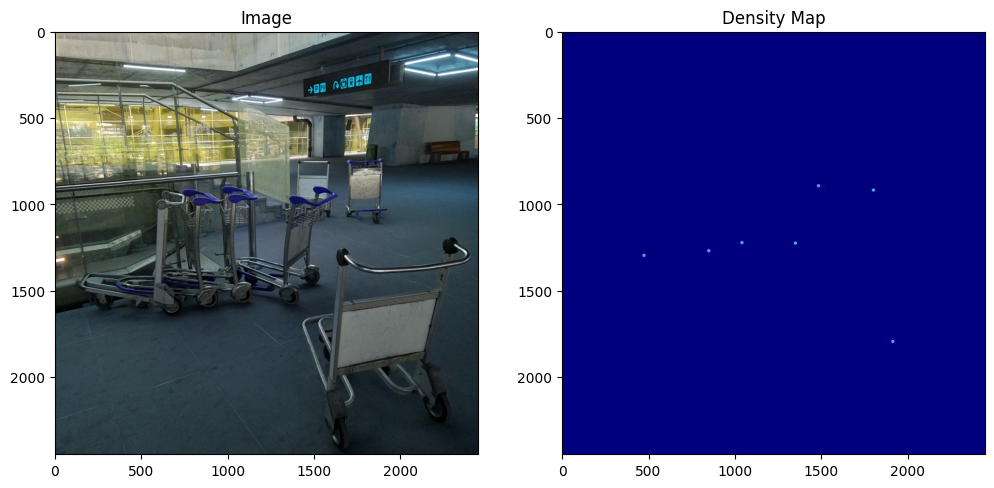

In [15]:
# Split dataset
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create generators
train_gen = DataGenerator(train_df, root_dir=root, batch_size=4)
valid_gen = DataGenerator(valid_df, root_dir=root, batch_size=4, shuffle=False)

# Test loading
X_batch, y_batch = train_gen[0]
print(f"Batch shape - X: {X_batch.shape}, y: {y_batch.shape}")

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X_batch[0])
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(y_batch[0].squeeze(), cmap='jet')
plt.title('Density Map')
plt.show()

In [20]:
import tensorflow as tf

print("TF Version:", tf.__version__)
print("CUDA Built:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    gpu = tf.config.list_physical_devices('GPU')[0]
    print("\nGPU Details:")
    print("Name:", gpu.name)
    print("Type:", gpu.device_type)
    print("Memory:", tf.config.experimental.get_memory_info(gpu.name))
else:
    print("\nNo GPU detected - Check these:")
    print("1. Are drivers installed?")
    print("2. Is CUDA/cuDNN installed?")
    print("3. Did you install tensorflow-gpu?")

TF Version: 2.19.0
CUDA Built: False
GPU Available: []

No GPU detected - Check these:
1. Are drivers installed?
2. Is CUDA/cuDNN installed?
3. Did you install tensorflow-gpu?


In [21]:
import torch
print("PyTorch CUDA available:", torch.cuda.is_available())
print("PyTorch CUDA device:", torch.cuda.get_device_name(0))

PyTorch CUDA available: True
PyTorch CUDA device: NVIDIA GeForce GTX 1650


In [22]:
import torch
print(f"PyTorch CUDA version: {torch.version.cuda}")  # e.g., "11.8"

PyTorch CUDA version: 11.8


In [25]:
import os

# Set CUDA paths (replace with your actual CUDA path)
os.environ["CUDA_HOME"] = "C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.8"  # Match your CUDA version
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["CUDA_HOME"], "bin")
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["CUDA_HOME"], "libnvvp")

# Verify paths
print("CUDA_HOME:", os.environ["CUDA_HOME"])
print("PATH contains CUDA:", "CUDA" in os.environ["PATH"])

CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
PATH contains CUDA: True


In [27]:
#Enable memory growth (avoids OOM errors)
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    
    # Limit GPU memory usage (optional)
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)]  # 3GB for TF, 1GB for system
    )

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D  # Also import the layers you're using
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
# Prepare the model
model = Sequential()
model.add(Conv2D(16, (11, 11), activation='relu', input_shape=(480, 640, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(24, (9, 9), activation='relu', padding='same'))
model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
model.add(Conv2D(8, (5, 5), activation='relu', padding='same'))

# Replace upsampling with deconvolution
model.add(Conv2DTranspose(8, (5, 5), strides=(4, 4), padding='same', activation='relu'))

# Final layer to get the output density map
model.add(Conv2D(1, (1, 1), activation='relu', padding='same'))
with tf.device('/GPU:0'):  # Explicitly place operations on GPU
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(
        train_gen,
        epochs=100,
        validation_data=valid_gen,
        verbose=2  # Compact progress output
    )

c:\Users\yasmi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()